In [1]:
#conifguration
import torch
import pandas as pd
from torch.utils.data import Dataset
import rasterio
from rasterio.windows import Window
import os
import cv2
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchmetrics import Dice

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

config = {
    'resize': (512,512), #(1024,1024)
    'DATA': '/kaggle/input/hubmap-organ-segmentation/train_images',
    'MASKS' : '/kaggle/input/hubmap-organ-segmentation/train.csv',
    'Window' : (0,3000), #(250,2670)
}

!mkdir -p /tmp/pip/cache/
!cp ../input/segmentationmodels/pretrainedmodels-0.7.4.xyz /tmp/pip/cache/pretrainedmodels-0.7.4.tar.gz
!cp ../input/segmentationmodels/segmentation_models_pytorch-0.3.1-py3-none-any.whl /tmp/pip/cache/
!cp ../input/segmentationmodels/efficientnet_pytorch-0.7.1.xyz /tmp/pip/cache/efficientnet_pytorch-0.7.1.tar.gz
!cp ../input/segmentationmodels/timm-0.4.12-py3-none-any.whl /tmp/pip/cache/
!pip install --no-index --find-links /tmp/pip/cache/ segmentation-models-pytorch

Looking in links: /tmp/pip/cache/
Processing /tmp/pip/cache/segmentation_models_pytorch-0.3.1-py3-none-any.whl
Processing /tmp/pip/cache/timm-0.4.12-py3-none-any.whl
Processing /tmp/pip/cache/pretrainedmodels-0.7.4.tar.gz
  Preparing metadata (setup.py) ... done
Processing /tmp/pip/cache/efficientnet_pytorch-0.7.1.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=bb05b4180b482f1a1b0ec538f621e9b3ed7abfdaaccdcae6b85f3ff2860c4695
  Stored in directory: /root/.cache/pip/wheels/02/50/84/82c97bfff69785108e55a6236d7ba11c83990eed25d4eab240
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=187e0c89c14f3ba3f843d1c42a0d1706051d6ebd1957d59f9da5280ff59c99b3
  Stored in directory: /root/.cache/pip/wheels/10/1f/03/61c3da39f4907ac6ad69ce8078e5be835c4681b842d110d52f
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
#load saved best models
import sys
sys.path.append("../input/unetbest")
from SimpleUNet import UNetModel
from unet_utils import ConvBlock
from unet_utils import DownBlock
from unet_utils import UpBlock
from unet_utils import OutBlock

# model = torch.load("/kaggle/input/transfermodel/best.sav", map_location='cpu').to(device)
# U-Net
model = torch.load("/kaggle/input/unetbest/unet.sav", map_location='cpu').to(device)
# Efficient-Net
Emodel = torch.load("/kaggle/input/efficientnet/Ebest.sav", map_location='cpu').to(device)

In [3]:
#split test set
df_masks = pd.read_csv("/kaggle/input/hubmap-organ-segmentation/train.csv")[['id', 'rle','organ']].set_index('id')

kidney = df_masks.loc[df_masks["organ"] == "kidney"].index.values.tolist()
prostate = df_masks.loc[df_masks["organ"] == "prostate"].index.values.tolist()
largeintestine = df_masks.loc[df_masks["organ"] == "largeintestine"].index.values.tolist()
spleen = df_masks.loc[df_masks["organ"] == "spleen"].index.values.tolist()
lung = df_masks.loc[df_masks["organ"] == "lung"].index.values.tolist()

val_split = 0.9

test = kidney[int(len(kidney)*val_split):] + \
        prostate[int(len(prostate)*val_split):] + \
        largeintestine[int(len(largeintestine)*val_split):] + \
        spleen[int(len(spleen)*val_split):] + \
        lung[int(len(lung)*val_split):]

In [4]:
#Helper functions
#convert encoding rle to mask
def enc2mask(encs, shape):
    '''
    Args:
    encs: list of rle masks
    shape: mask shape
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for m,enc in enumerate(encs):
        if isinstance(enc,np.float32) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1 + m
    return img.reshape(shape).T

def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [5]:
class HPADataset(Dataset):
    def __init__(self): #transform=None, target_transform=None
        self.total = 0
        self.img = []
        self.mask = []
    
        tempid = test
        
        for index in tempid:
            row = df_masks.loc[index]
            dp = HPAData(index,encs=row)
            img, m, idx = dp[0]

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            transform = transforms.Compose([
                transforms.ToTensor()
            ])
            
            tensorImg = transform(img)
            tensorMask = torch.as_tensor(np.array(m), dtype=torch.int64)

            self.img.append(tensorImg)
            self.mask.append(tensorMask)
            self.total+=1
            
    def __len__(self):
        return self.total
    
    def __getitem__(self, idx):
        image = self.img[idx]
        mask = self.mask[idx]
        
        return image, mask
    
#resize & cutoff each image mask pair with consistent dim
class HPAData():
    def __init__(self, idx, resize=config['resize'], slide=config['Window'], encs=None):
        self.data = rasterio.open(os.path.join(config['DATA'],str(idx)+'.tiff'), num_threads='all_cpus')
#         print(self.data)
        
        # some images have issues with their format 
        # and must be saved correctly before reading with rasterio
        if self.data.count != 3:
            subdatasets = self.data.subdatasets
            self.layers = []
            if len(subdatasets) > 0:
                for i, subdataset in enumerate(subdatasets, 0):
                    self.layers.append(rasterio.open(subdataset))
                    
        self.shape = self.data.shape
        self.slide = slide
        self.resize = resize
        self.idx = idx
        
        self.mask = enc2mask(encs,(self.shape[1],self.shape[0])) if encs is not None else None
        
    def __len__(self):
        return 1
    
    def __getitem__(self, idx):
        # read img (RGB), mask (grayscale) from window slide
        # img, mask: uint8
        img = self.data.read([1,2,3],window=Window.from_slices(self.slide,self.slide)) 
        mask = self.mask[self.slide[0]:self.slide[1], self.slide[0]:self.slide[1]] 
        
        # resize
        img = cv2.resize(np.transpose(img,(1,2,0)),(self.resize[0],self.resize[1]),
                         interpolation = cv2.INTER_AREA)
        mask = cv2.resize(mask,(self.resize[0], self.resize[1]),
                          interpolation = cv2.INTER_NEAREST)
        
        return img, mask, self.idx

In [6]:
testset = HPADataset()

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [7]:
print(len(test))
print(test)
#0-9 Kidney
#10-19 Prostate
#20-25 Largeintestine
#26-31 Spleen
#32-36 Lung

print(df_masks.loc[test[0]]["organ"])
# print(df_masks.loc[test[0]]["rle"])

print(test[0])
print(test[10])
print(test[20])
print(test[26])
print(test[32])

print(testset)

37
[6807, 7569, 7970, 8502, 9437, 9445, 9470, 9517, 9769, 9791, 7397, 7706, 7902, 8227, 8388, 8638, 8842, 9231, 928, 9358, 8222, 8402, 8450, 8752, 9777, 9904, 7169, 8116, 8876, 8894, 9407, 9453, 8151, 8231, 8343, 9387, 9450]
kidney
6807
7397
8222
7169
8151


In [8]:
#test[0] 6807 kidney
#test[10] 7397 Prostate
#20 8222 Largeintestine
#26 7169 Spleen
#32 8151 Lung
img_ind = 10

import tifffile as tiff 
img_id_1 = test[img_ind]
img_1 = tiff.imread("../input/hubmap-organ-segmentation/train_images/" + str(img_id_1) + ".tiff")
# # print(img_1.shape)
# plt.figure(figsize=(10, 10))
# plt.imshow(img_1, cmap='coolwarm', alpha=0.5)
# # plt.imshow(testset.mask[img_ind], cmap='coolwarm', alpha=0.5)
# plt.axis("off")


mask_1 = rle2mask(df_masks.loc[img_id_1]["rle"], (img_1.shape[1], img_1.shape[0]))
# plt.figure(figsize=(10,10))
# plt.imshow(mask_1, cmap='coolwarm', alpha=0.5)
# plt.axis("off")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


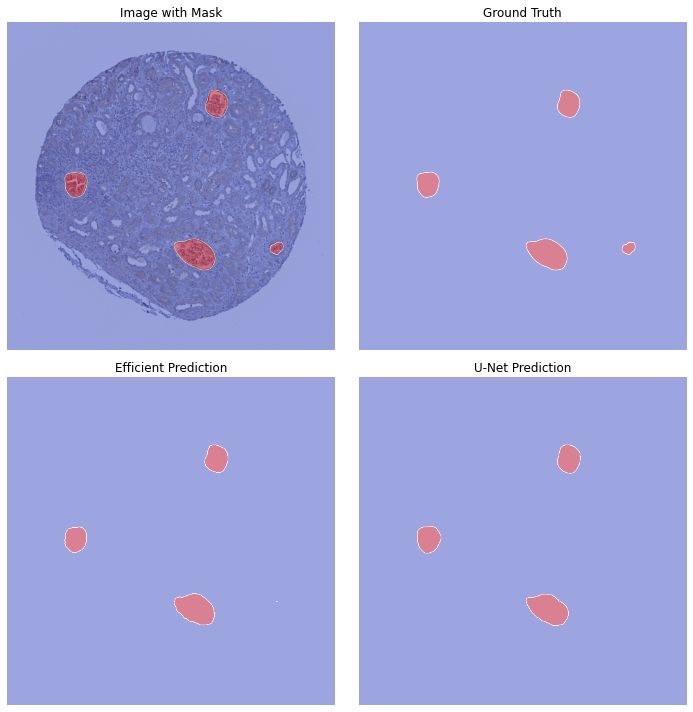

In [9]:
img_ind = 0

import tifffile as tiff 
img_id_1 = test[img_ind]
img_1 = tiff.imread("../input/hubmap-organ-segmentation/train_images/" + str(img_id_1) + ".tiff")
mask_1 = rle2mask(df_masks.loc[img_id_1]["rle"], (img_1.shape[1], img_1.shape[0]))

f, axarr = plt.subplots(2,2, figsize=(10,10))#3 

axarr[0, 0].axis('off')
axarr[0, 1].axis('off')
axarr[1, 0].axis('off')
axarr[1, 1].axis('off')

axarr[0, 0].imshow(img_1)
axarr[0, 0].imshow(mask_1, cmap='coolwarm', alpha=0.5)
axarr[0, 1].imshow(mask_1, cmap='coolwarm', alpha=0.5)
axarr[1, 0].imshow(torch.round(torch.sigmoid(model(torch.tensor(testset.img[img_ind], dtype=torch.float32).unsqueeze(axis=0).to('cuda')))).to('cpu').squeeze(0).detach().numpy()[0, :, :], cmap='coolwarm', alpha=0.5)
axarr[1, 1].imshow(torch.round(torch.sigmoid(Emodel(torch.tensor(testset.img[img_ind], dtype=torch.float32).unsqueeze(axis=0).to('cuda')))).to('cpu').squeeze(0).detach().numpy()[0, :, :], cmap='coolwarm', alpha=0.5)

axarr[0, 0].set_title("Image with Mask")
axarr[0, 1].set_title("Ground Truth")
axarr[1, 0].set_title("Efficient Prediction")
axarr[1, 1].set_title("U-Net Prediction")

f.tight_layout()
f.savefig('Kidney.png', dpi=300)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


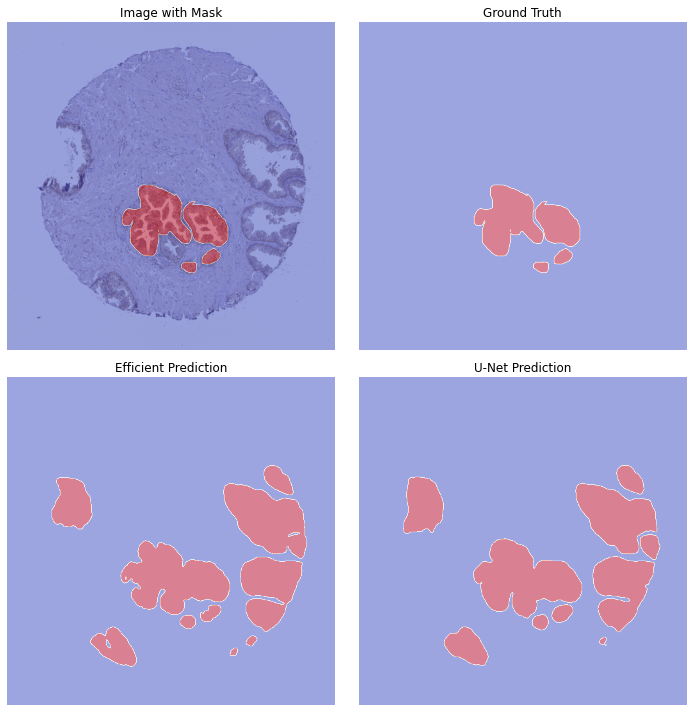

In [10]:
img_ind = 10

import tifffile as tiff 
img_id_1 = test[img_ind]
img_1 = tiff.imread("../input/hubmap-organ-segmentation/train_images/" + str(img_id_1) + ".tiff")
mask_1 = rle2mask(df_masks.loc[img_id_1]["rle"], (img_1.shape[1], img_1.shape[0]))

f, axarr = plt.subplots(2,2, figsize=(10,10))#3 

axarr[0, 0].axis('off')
axarr[0, 1].axis('off')
axarr[1, 0].axis('off')
axarr[1, 1].axis('off')

axarr[0, 0].imshow(img_1)
axarr[0, 0].imshow(mask_1, cmap='coolwarm', alpha=0.5)
axarr[0, 1].imshow(mask_1, cmap='coolwarm', alpha=0.5)
axarr[1, 0].imshow(torch.round(torch.sigmoid(model(torch.tensor(testset.img[img_ind], dtype=torch.float32).unsqueeze(axis=0).to('cuda')))).to('cpu').squeeze(0).detach().numpy()[0, :, :], cmap='coolwarm', alpha=0.5)
axarr[1, 1].imshow(torch.round(torch.sigmoid(Emodel(torch.tensor(testset.img[img_ind], dtype=torch.float32).unsqueeze(axis=0).to('cuda')))).to('cpu').squeeze(0).detach().numpy()[0, :, :], cmap='coolwarm', alpha=0.5)

axarr[0, 0].set_title("Image with Mask")
axarr[0, 1].set_title("Ground Truth")
axarr[1, 0].set_title("Efficient Prediction")
axarr[1, 1].set_title("U-Net Prediction")

f.tight_layout()
f.savefig('Prostate.png', dpi=300)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


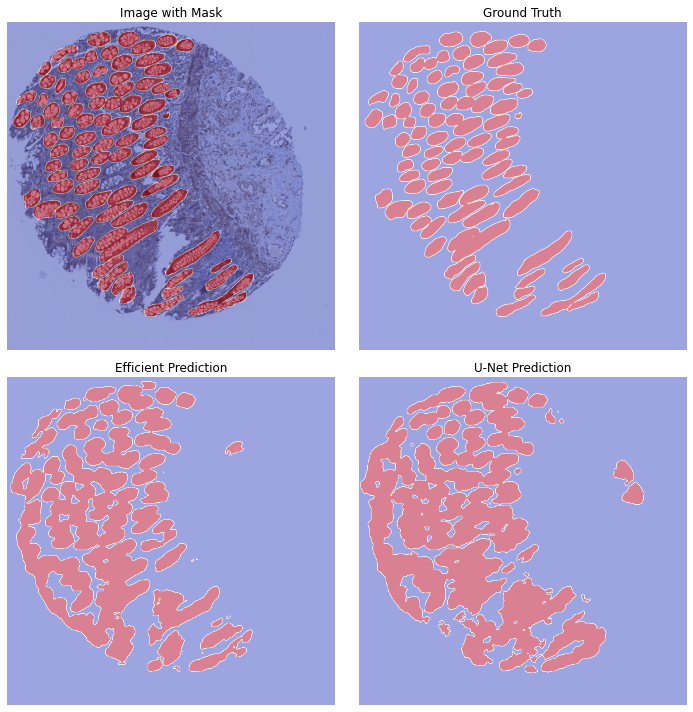

In [11]:
img_ind = 20

import tifffile as tiff 
img_id_1 = test[img_ind]
img_1 = tiff.imread("../input/hubmap-organ-segmentation/train_images/" + str(img_id_1) + ".tiff")
mask_1 = rle2mask(df_masks.loc[img_id_1]["rle"], (img_1.shape[1], img_1.shape[0]))

f, axarr = plt.subplots(2,2, figsize=(10,10))#3 

axarr[0, 0].axis('off')
axarr[0, 1].axis('off')
axarr[1, 0].axis('off')
axarr[1, 1].axis('off')

axarr[0, 0].imshow(img_1)
axarr[0, 0].imshow(mask_1, cmap='coolwarm', alpha=0.5)
axarr[0, 1].imshow(mask_1, cmap='coolwarm', alpha=0.5)
axarr[1, 0].imshow(torch.round(torch.sigmoid(model(torch.tensor(testset.img[img_ind], dtype=torch.float32).unsqueeze(axis=0).to('cuda')))).to('cpu').squeeze(0).detach().numpy()[0, :, :], cmap='coolwarm', alpha=0.5)
axarr[1, 1].imshow(torch.round(torch.sigmoid(Emodel(torch.tensor(testset.img[img_ind], dtype=torch.float32).unsqueeze(axis=0).to('cuda')))).to('cpu').squeeze(0).detach().numpy()[0, :, :], cmap='coolwarm', alpha=0.5)

axarr[0, 0].set_title("Image with Mask")
axarr[0, 1].set_title("Ground Truth")
axarr[1, 0].set_title("Efficient Prediction")
axarr[1, 1].set_title("U-Net Prediction")

f.tight_layout()
f.savefig('Largeintestine.png', dpi=300)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


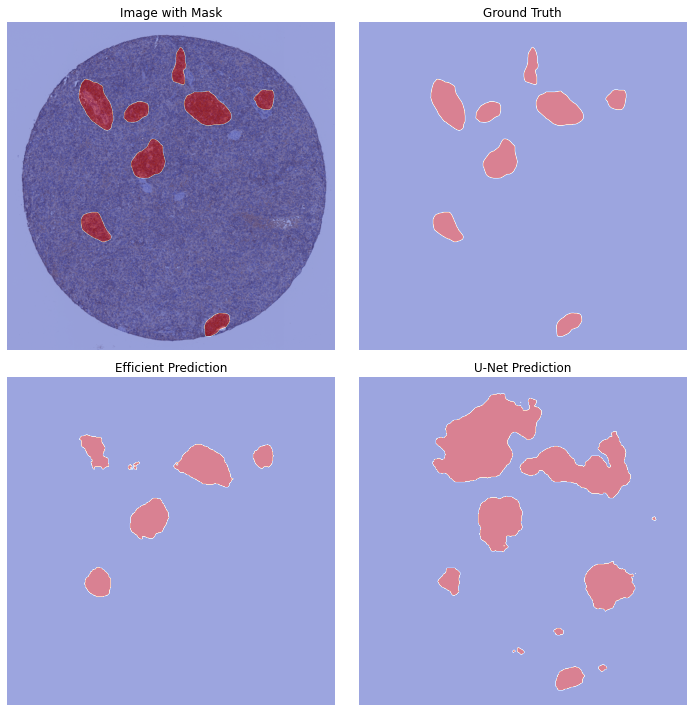

In [12]:
img_ind = 26

import tifffile as tiff 
img_id_1 = test[img_ind]
img_1 = tiff.imread("../input/hubmap-organ-segmentation/train_images/" + str(img_id_1) + ".tiff")
mask_1 = rle2mask(df_masks.loc[img_id_1]["rle"], (img_1.shape[1], img_1.shape[0]))

f, axarr = plt.subplots(2,2, figsize=(10,10))#3 

axarr[0, 0].axis('off')
axarr[0, 1].axis('off')
axarr[1, 0].axis('off')
axarr[1, 1].axis('off')

axarr[0, 0].imshow(img_1)
axarr[0, 0].imshow(mask_1, cmap='coolwarm', alpha=0.5)
axarr[0, 1].imshow(mask_1, cmap='coolwarm', alpha=0.5)
axarr[1, 0].imshow(torch.round(torch.sigmoid(model(torch.tensor(testset.img[img_ind], dtype=torch.float32).unsqueeze(axis=0).to('cuda')))).to('cpu').squeeze(0).detach().numpy()[0, :, :], cmap='coolwarm', alpha=0.5)
axarr[1, 1].imshow(torch.round(torch.sigmoid(Emodel(torch.tensor(testset.img[img_ind], dtype=torch.float32).unsqueeze(axis=0).to('cuda')))).to('cpu').squeeze(0).detach().numpy()[0, :, :], cmap='coolwarm', alpha=0.5)

axarr[0, 0].set_title("Image with Mask")
axarr[0, 1].set_title("Ground Truth")
axarr[1, 0].set_title("Efficient Prediction")
axarr[1, 1].set_title("U-Net Prediction")

f.tight_layout()
f.savefig('Spleen.png', dpi=300)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


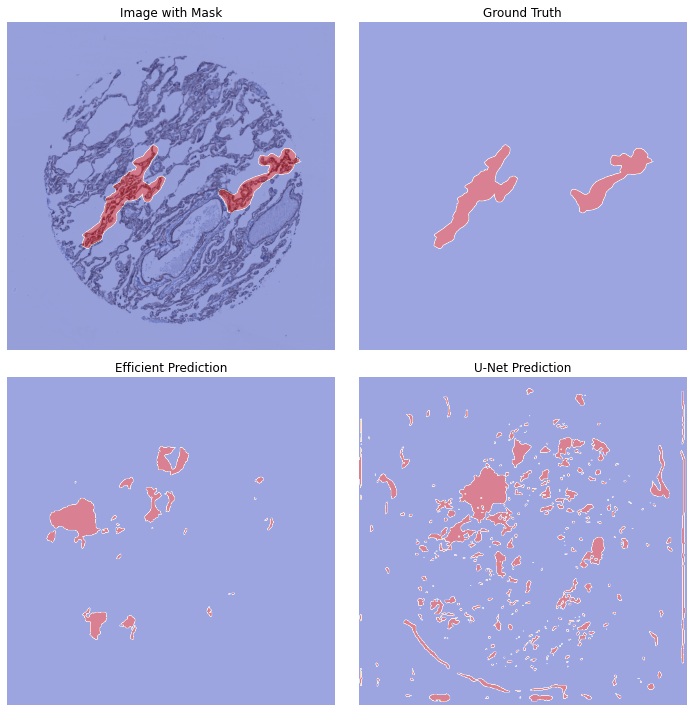

In [13]:
img_ind = 32

import tifffile as tiff 
img_id_1 = test[img_ind]
img_1 = tiff.imread("../input/hubmap-organ-segmentation/train_images/" + str(img_id_1) + ".tiff")
mask_1 = rle2mask(df_masks.loc[img_id_1]["rle"], (img_1.shape[1], img_1.shape[0]))

f, axarr = plt.subplots(2,2, figsize=(10,10))#3 

axarr[0, 0].axis('off')
axarr[0, 1].axis('off')
axarr[1, 0].axis('off')
axarr[1, 1].axis('off')

axarr[0, 0].imshow(img_1)
axarr[0, 0].imshow(mask_1, cmap='coolwarm', alpha=0.5)
axarr[0, 1].imshow(mask_1, cmap='coolwarm', alpha=0.5)
axarr[1, 0].imshow(torch.round(torch.sigmoid(model(torch.tensor(testset.img[img_ind], dtype=torch.float32).unsqueeze(axis=0).to('cuda')))).to('cpu').squeeze(0).detach().numpy()[0, :, :], cmap='coolwarm', alpha=0.5)
axarr[1, 1].imshow(torch.round(torch.sigmoid(Emodel(torch.tensor(testset.img[img_ind], dtype=torch.float32).unsqueeze(axis=0).to('cuda')))).to('cpu').squeeze(0).detach().numpy()[0, :, :], cmap='coolwarm', alpha=0.5)

axarr[0, 0].set_title("Image with Mask")
axarr[0, 1].set_title("Ground Truth")
axarr[1, 0].set_title("Efficient Prediction")
axarr[1, 1].set_title("U-Net Prediction")

f.tight_layout()
f.savefig('Lung.png', dpi=300)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


[0.9355117678642273]
[0.9355117678642273, 0.4363807439804077]
[0.9355117678642273, 0.4363807439804077, 0.7822896838188171]
[0.9355117678642273, 0.4363807439804077, 0.7822896838188171, 0.7039193511009216]
[0.9355117678642273, 0.4363807439804077, 0.7822896838188171, 0.7039193511009216, 0.047822896391153336]
[0.9349877834320068]
[0.9349877834320068, 0.45429715514183044]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[0.9349877834320068, 0.45429715514183044, 0.7404775619506836]
[0.9349877834320068, 0.45429715514183044, 0.7404775619506836, 0.4327758848667145]
[0.9349877834320068, 0.45429715514183044, 0.7404775619506836, 0.4327758848667145, 0.07100668549537659]


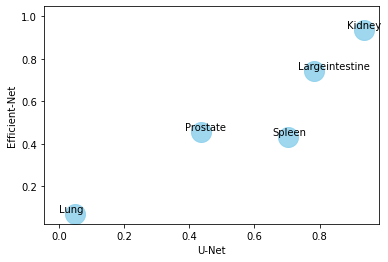

In [14]:
#test[0] 6807 kidney
#test[10] 7397 Prostate
#20 8222 Largeintestine
#26 7169 Spleen
#32 8151 Lung
img_ind = [0, 10, 20, 26, 32]

import seaborn as sns
x = []
y = []
group = ['Kidney','Prostate','Largeintestine','Spleen','Lung']

for i in img_ind:
    metric = Dice(average='micro')
    pred = torch.round(torch.sigmoid(model(torch.tensor(testset.img[i], dtype=torch.float32).unsqueeze(axis=0).to('cuda')))).to('cpu')
    target = torch.as_tensor(testset.mask[i])
    x.append(metric(pred, target).item())
    print(x)
    
for i in img_ind:
    metric = Dice(average='micro')
    pred = torch.round(torch.sigmoid(Emodel(torch.tensor(testset.img[i], dtype=torch.float32).unsqueeze(axis=0).to('cuda')))).to('cpu')
    target = torch.as_tensor(testset.mask[i])
    y.append(metric(pred, target).item())
    print(y)
    
# sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="+", color="skyblue")
# plt.show()

fig, ax = plt.subplots()

# Create dataframe
df = pd.DataFrame({
'x': x,
'y': y,
'group': group
})

# basic plot
sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})

# add annotations one by one with a loop
for line in range(0,df.shape[0]):
     plt.text(df.x[line]-0.05, df.y[line]+0.01, df.group[line], horizontalalignment='left', size='medium', color='black')


plt.xlabel('U-Net')
plt.ylabel('Efficient-Net')
plt.plot([0, 0], [1, 1], linewidth=1)
fig.show()

fig.savefig('scatter.png', dpi=300)

In [15]:
#0-9 6807 kidney
img_ind = 10
k = []
for i in range(0,img_ind):
    metric = Dice(average='micro')
    pred = torch.round(torch.sigmoid(model(torch.tensor(testset.img[i], dtype=torch.float32).unsqueeze(axis=0).to('cuda')))).to('cpu')
    target = torch.as_tensor(testset.mask[i])
    k.append(metric(pred, target).item())
#     print(m)
x1 = sum(k)/10

k = []
for i in range(0,img_ind):
    metric = Dice(average='micro')
    pred = torch.round(torch.sigmoid(Emodel(torch.tensor(testset.img[i], dtype=torch.float32).unsqueeze(axis=0).to('cuda')))).to('cpu')
    target = torch.as_tensor(testset.mask[i])
    k.append(metric(pred, target).item())
#     print(m)
y1 = sum(k)/10

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


In [16]:
#10-19 7397 Prostate
img_ind = 20
p = []
for i in range(10,img_ind):
    metric = Dice(average='micro')
    pred = torch.round(torch.sigmoid(model(torch.tensor(testset.img[i], dtype=torch.float32).unsqueeze(axis=0).to('cuda')))).to('cpu')
    target = torch.as_tensor(testset.mask[i])
    p.append(metric(pred, target).item())
#     print(m)
x2 = sum(p)/10

p = []
for i in range(10,img_ind):
    metric = Dice(average='micro')
    pred = torch.round(torch.sigmoid(Emodel(torch.tensor(testset.img[i], dtype=torch.float32).unsqueeze(axis=0).to('cuda')))).to('cpu')
    target = torch.as_tensor(testset.mask[i])
    p.append(metric(pred, target).item())
#     print(m)
y2 = sum(p)/10

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


In [17]:
#20-26 8222 Largeintestine
img_ind = 26
l = []
for i in range(20,img_ind):
    metric = Dice(average='micro')
    pred = torch.round(torch.sigmoid(model(torch.tensor(testset.img[i], dtype=torch.float32).unsqueeze(axis=0).to('cuda')))).to('cpu')
    target = torch.as_tensor(testset.mask[i])
    l.append(metric(pred, target).item())
#     print(m)
x3 = sum(l)/10

l = []
for i in range(20,img_ind):
    metric = Dice(average='micro')
    pred = torch.round(torch.sigmoid(Emodel(torch.tensor(testset.img[i], dtype=torch.float32).unsqueeze(axis=0).to('cuda')))).to('cpu')
    target = torch.as_tensor(testset.mask[i])
    l.append(metric(pred, target).item())
#     print(m)
y3 = sum(l)/10

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


In [18]:
#26 31 7169 Spleen
img_ind = 32
s = []
for i in range(26,img_ind):
    metric = Dice(average='micro')
    pred = torch.round(torch.sigmoid(model(torch.tensor(testset.img[i], dtype=torch.float32).unsqueeze(axis=0).to('cuda')))).to('cpu')
    target = torch.as_tensor(testset.mask[i])
    s.append(metric(pred, target).item())
#     print(m)
x4 = sum(s)/10

s = []
for i in range(26,img_ind):
    metric = Dice(average='micro')
    pred = torch.round(torch.sigmoid(Emodel(torch.tensor(testset.img[i], dtype=torch.float32).unsqueeze(axis=0).to('cuda')))).to('cpu')
    target = torch.as_tensor(testset.mask[i])
    s.append(metric(pred, target).item())
#     print(m)
y4 = sum(s)/10

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


In [19]:
#32 36 8151 Lung
img_ind = 37
lu = []
for i in range(32,img_ind):
    metric = Dice(average='micro')
    pred = torch.round(torch.sigmoid(model(torch.tensor(testset.img[i], dtype=torch.float32).unsqueeze(axis=0).to('cuda')))).to('cpu')
    target = torch.as_tensor(testset.mask[i])
    lu.append(metric(pred, target).item())
#     print(m)
x5 = sum(lu)/10

lu = []
for i in range(32,img_ind):
    metric = Dice(average='micro')
    pred = torch.round(torch.sigmoid(Emodel(torch.tensor(testset.img[i], dtype=torch.float32).unsqueeze(axis=0).to('cuda')))).to('cpu')
    target = torch.as_tensor(testset.mask[i])
    lu.append(metric(pred, target).item())
#     print(m)
y5 = sum(lu)/10

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


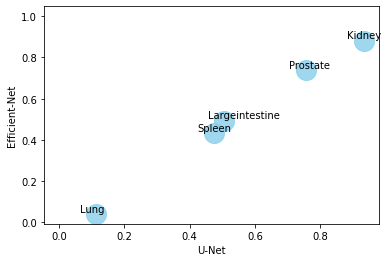

In [20]:
img_ind = [0, 10, 20, 26, 32]

import seaborn as sns
x = [x1, x2, x3, x4, x5]
y = [y1, y2, y3, y4, y5]
group = ['Kidney','Prostate','Largeintestine','Spleen','Lung']
    
# sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="+", color="skyblue")
# plt.show()

fig, ax = plt.subplots()

# Create dataframe
df = pd.DataFrame({
'x': x,
'y': y,
'group': group
})

# basic plot
sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})

# add annotations one by one with a loop
for line in range(0,df.shape[0]):
     plt.text(df.x[line]-0.05, df.y[line]+0.01, df.group[line], horizontalalignment='left', size='medium', color='black')


plt.xlabel('U-Net')
plt.ylabel('Efficient-Net')
plt.plot([0, 0], [1, 1], linewidth=1)
fig.show()

fig.savefig('scatter.png', dpi=300)